# MonteCarlo Simulation

### How to calculate the value of Pi using MonteCarlo. Here is the demostration of it:
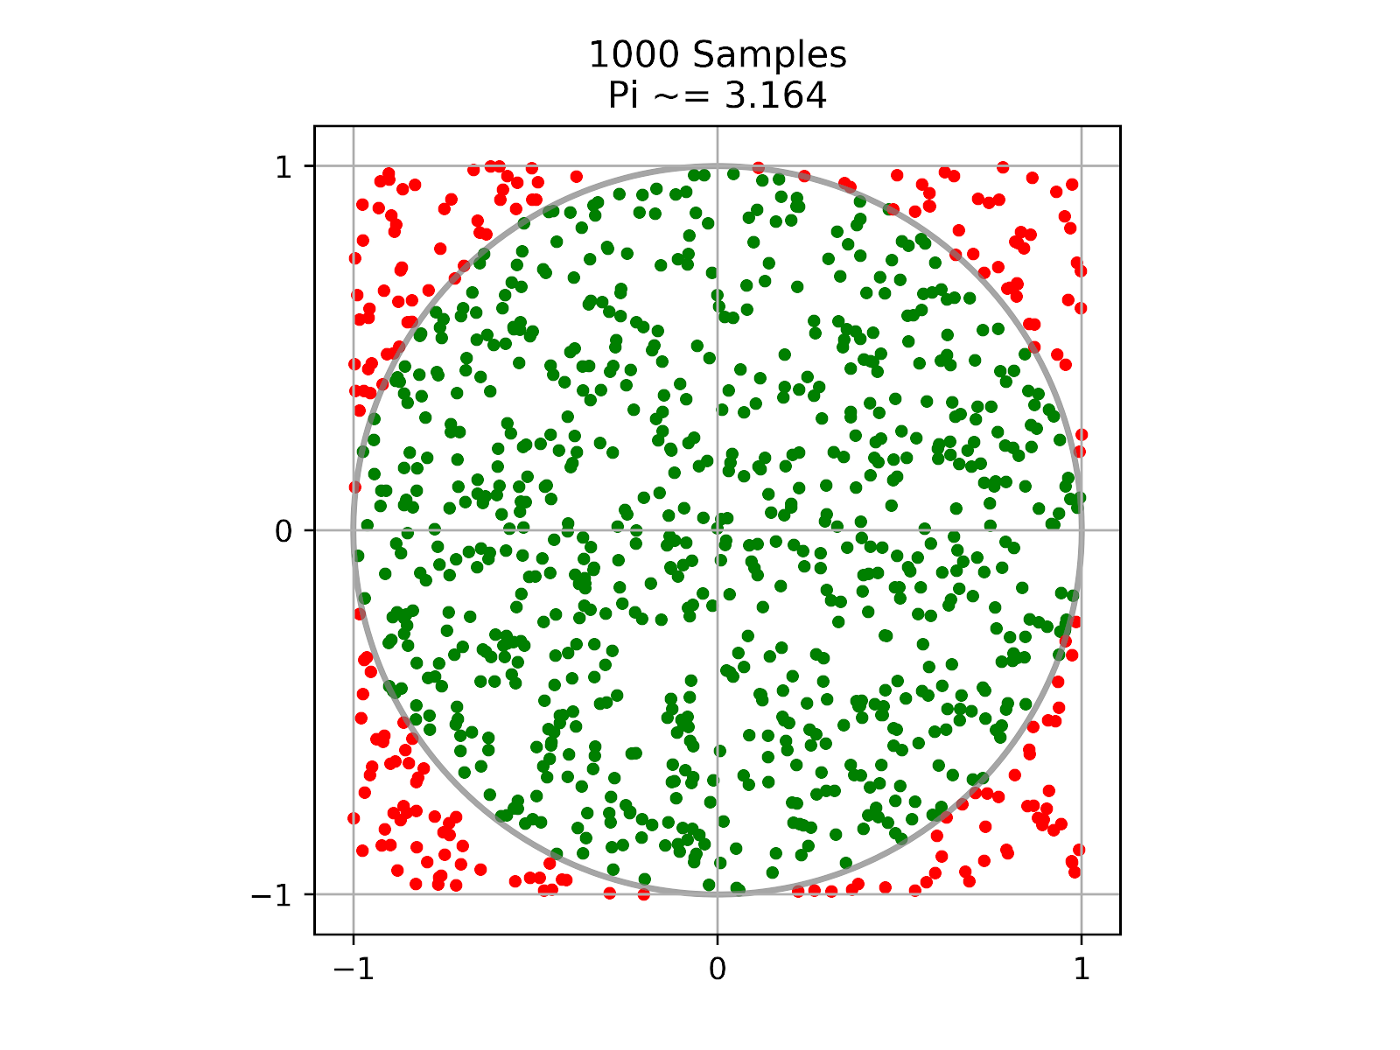

To estimate the value of π using a Monte Carlo method, we can employ a technique that involves randomly sampling points within a 2x2 square. This square is defined with its corners at the coordinates (0,0), (2,0), (0,2), and (2,2). Within this square, we inscribe a unit circle centered at the origin (0,0) with a radius of 1.

The process involves the following steps:

1. **Random Sampling**: Generate a large number of random points within the 2x2 square. Each point can be represented by its coordinates (x, y), where both x and y are uniformly distributed between 0 and 2.

2. **Determine Points Inside the Circle**: For each randomly generated point, determine whether it lies within the unit circle. A point (x, y) is inside the circle if the condition \(x^2 + y^2 \leq 1\) is satisfied.

3. **Calculate the Ratio**: After sampling a sufficient number of points, calculate the proportion of points that fall within the unit circle compared to the total number of points sampled. This ratio approximates the area of the circle relative to the area of the square.

4. **Estimate π**: Since the area of the unit circle is π and the area of the 2x2 square is 4, the theoretical ratio of the areas is π/4. Therefore, to estimate the value of π, multiply the calculated ratio by 4.

5. **Increase Accuracy**: The accuracy of this approximation improves with an increasing number of sampled points. As the sample size grows, the estimated value of π converges towards its true value.

The Monte Carlo method provides a probabilistic approach to estimating π by leveraging geometric relationships and random sampling, yielding increasingly accurate results with larger datasets.

## Monte Carlo using Naive python approach

In [1]:
import random

def monte_carlo_pi(num_samples):
    inside_circle = 0

    for _ in range(num_samples):
        x, y = random.uniform(0, 1), random.uniform(0, 1)
        if x**2 + y**2 <= 1:
            inside_circle += 1

    pi_estimate = (inside_circle / num_samples) * 4
    return pi_estimate

num_samples = 1000000
pi_estimate = monte_carlo_pi(num_samples)
print(f"Estimated value of pi: {pi_estimate}")


Estimated value of pi: 3.14196


## Monte Carlo using Ray

Ray is an open-source framework designed for building and running distributed applications, particularly in Python. It simplifies the process of parallelizing code, enabling developers to easily scale applications across multiple CPUs and GPUs. With a flexible programming model that supports tasks and actors, Ray allows for efficient execution of workloads in a distributed environment. It also offers dynamic resource allocation, fault tolerance, and specialized libraries for machine learning, making it an ideal choice for performance-intensive applications in data science and beyond.

In [1]:
# install ray Module 
# run this command to install ray

# !pip install -U ray

In [1]:
import ray
import math
import time
import random

ray.init()

2024-08-02 10:41:22,399	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-02 10:41:27,318	INFO worker.py:1781 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.34.0


In [4]:
# Define progress actor that can be called by sampling tasks to update progress
@ray.remote
class ProgressActor:
    def __init__(self, total_num_samples: int):
        self.total_num_samples = total_num_samples
        self.num_samples_completed_per_task = {}

    def report_progress(self, task_id: int, num_samples_completed: int) -> None:
        self.num_samples_completed_per_task[task_id] = num_samples_completed

    def get_progress(self) -> float:
        return (
            sum(self.num_samples_completed_per_task.values()) / self.total_num_samples
        )

In [6]:
# Define sampling task
@ray.remote
def sampling_task(num_samples: int, task_id: int,
                  progress_actor: ray.actor.ActorHandle) -> int:
    num_inside = 0
    for i in range(num_samples):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        if math.hypot(x, y) <= 1:
            num_inside += 1

        # Report progress every 1 million samples.
        if (i + 1) % 1_000_000 == 0:
            # This is async.
            progress_actor.report_progress.remote(task_id, i + 1)

    # Report the final progress.
    progress_actor.report_progress.remote(task_id, num_samples)
    return num_inside

In [7]:
# Create progress actor
# Change this to match your cluster scale.
NUM_SAMPLING_TASKS = 10
NUM_SAMPLES_PER_TASK = 10_000_000
TOTAL_NUM_SAMPLES = NUM_SAMPLING_TASKS * NUM_SAMPLES_PER_TASK

# Create the progress actor.
progress_actor = ProgressActor.remote(TOTAL_NUM_SAMPLES)

In [8]:
# Execute sample task
# Create and execute all sampling tasks in parallel.
results = [
    sampling_task.remote(NUM_SAMPLES_PER_TASK, i, progress_actor)
    for i in range(NUM_SAMPLING_TASKS)
]

In [18]:
# Calculate Pi
# Get all the sampling tasks results.
total_num_inside = sum(ray.get(results))
pi = (total_num_inside * 4) / TOTAL_NUM_SAMPLES
print(f"Estimated value of π is: {pi}")

Estimated value of π is: 3.1416748
